In [1]:
import argparse
import os
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,wrap_fp16_model)

import mmdet
from mmdet3d.apis import single_gpu_test
from mmdet3d.datasets import build_dataloader, build_dataset
from mmdet3d.models import build_model
from mmdet.apis import multi_gpu_test, set_random_seed
from mmdet.datasets import replace_ImageToTensor

if mmdet.__version__ > '2.23.0':
    # If mmdet version > 2.23.0, setup_multi_processes would be imported and
    # used from mmdet instead of mmdet3d.
    from mmdet.utils import setup_multi_processes
else:
    from mmdet3d.utils import setup_multi_processes

try:
    # If mmdet version > 2.23.0, compat_cfg would be imported and
    # used from mmdet instead of mmdet3d.
    from mmdet.utils import compat_cfg
except ImportError:
    from mmdet3d.utils import compat_cfg
    
import json
import pickle
import cv2
import numpy as np
from pyquaternion.quaternion import Quaternion
from mmdet3d.core.bbox.structures.lidar_box3d import LiDARInstance3DBoxes as LB

from nuscenes.utils.data_classes import Box, LidarPointCloud
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from PIL import Image
from pyquaternion import Quaternion
import pyquaternion

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from collections import OrderedDict
import glob
from math import pi
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# PoseNet
import torchvision.models as models
from torch import nn
import math
import torch.nn.functional as F
from torchvision import transforms
from scipy.spatial.transform import Rotation as R


# Pose Network (from Manydepth)

In [2]:
def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)
    
    # print("R: ", R)
    # print("R[:3, :3]: ", R[:, :3, :3])
    # print("T: ", T)
    # print("T[~]: ", T[:, :3, -1])
    
    # R, T를 이어 붙여서 return
    M = R.new_zeros((4, 4))
    M[3, 3] = 1
    M[:3, :3] = R[:, :3, :3]
    M[:3, -1] = T[:, :3, -1]

    # R, T 간의 행렬곱을 return
    # if invert:
    #     M = torch.matmul(R, T)
    # else:
    #     M = torch.matmul(T, R)

    return M

def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T

def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """

    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
    blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
    block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    if pretrained:
        loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
        loaded['conv1.weight'] = torch.cat(
            [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
        model.load_state_dict(loaded)
    return model

"""Pose Encoder"""
class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder"""
    def __init__(self, num_layers, pretrained, num_input_images=1, **kwargs):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

"""Pose Decoder"""
class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__()

        self.num_ch_enc = num_ch_enc
        self.num_input_features = num_input_features

        if num_frames_to_predict_for is None:
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = [f[-1] for f in input_features]

        cat_features = [self.relu(self.convs["squeeze"](f)) for f in last_features]
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.01 * out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

## Tangent Patch Generation

In [3]:
def createProjectGrid(erp_h, erp_w, tangent_h, tangent_w, num_rows, num_cols, phi_centers, fov):
    height, width = tangent_h, tangent_w

    FOV = fov
    FOV = [FOV[0] / 360.0, FOV[1] / 180.0]
    FOV = torch.tensor(FOV, dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2

    yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
    screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)

    num_rows = num_rows
    num_cols = num_cols
    phi_centers = phi_centers

    phi_interval = 180 // num_rows
    all_combos = []
    erp_mask = []

    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols): # 0 ~ num_cols.length
            theta_interval = 360 / n_cols # 현재 row (위도)에서 쪼개질 경도 (col)의 위치
            theta_center = j * theta_interval + theta_interval / 2
            center = [theta_center, phi_centers[i]] # 각 tangent image의 center position

            # print(str(j) + " th theta center " + str(theta_center) + " phi center " + str(phi_centers[i]))
            
            all_combos.append(center)

            # 구좌표계에서의 tangent image가 차지하는 영역에 대한 좌표들
            up = phi_centers[i] + phi_interval / 2
            down = phi_centers[i] - phi_interval / 2
            left = theta_center - theta_interval / 2
            right = theta_center + theta_interval / 2

            # ERP image에서 현재 tangent가 차지하는 영역에 대한 pixel 위치들
            up = int((up + 90) / 180 * erp_h)
            down = int((down + 90) / 180 * erp_h)
            left = int(left / 360 * erp_w)
            right = int(right / 360 * erp_w)

            # ERP 이미지에서 현재 tangent image 영역에 해당하는 부분에 1로 마스킹
            mask = np.zeros((erp_h, erp_w), dtype=int)
            mask[down:up, left:right] = 1
            erp_mask.append(mask)

    all_combos = np.vstack(all_combos)
    shifts = np.arange(all_combos.shape[0]) * width
    shifts = torch.from_numpy(shifts).float()
    erp_mask = np.stack(erp_mask)
    erp_mask = torch.from_numpy(erp_mask).float()
    n_patch = all_combos.shape[0]
    
    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)

    convertedCoord = screen_points * 2 - 1
    convertedCoord[:, 0] = convertedCoord[:, 0] * PI
    convertedCoord[:, 1] = convertedCoord[:, 1] * PI_2
    convertedCoord = convertedCoord * (torch.ones(screen_points.shape, dtype=torch.float32) * FOV)
    convertedCoord = convertedCoord.unsqueeze(0).repeat(cp.shape[0], 1, 1)

    x = convertedCoord[:, :, 0]
    y = convertedCoord[:, :, 1]

    rou = torch.sqrt(x ** 2 + y ** 2)
    c = torch.atan(rou)
    sin_c = torch.sin(c)
    cos_c = torch.cos(c)
    lat = torch.asin(cos_c * torch.sin(cp[:, :, 1]) + (y * sin_c * torch.cos(cp[:, :, 1])) / rou)
    lon = cp[:, :, 0] + torch.atan2(x * sin_c, rou * torch.cos(cp[:, :, 1]) * cos_c - y * torch.sin(cp[:, :, 1]) * sin_c)
    lat_new = lat / PI_2
    lon_new = lon / PI
    lon_new[lon_new > 1] -= 2
    lon_new[lon_new<-1] += 2

    lon_new = lon_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
    lat_new = lat_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
    
    grid = torch.stack([lon_new, lat_new], -1)
    grid = grid.unsqueeze(0)

    return n_patch, grid

# Utils

In [4]:
def get_quaternion_from_euler(e):
    """
    Convert an Euler angle to a quaternion.

    Input
    :param roll: The roll (rotation around x-axis) angle in radians.
    :param pitch: The pitch (rotation around y-axis) angle in radians.
    :param yaw: The yaw (rotation around z-axis) angle in radians.

    Output
    :return qx, qy, qz, qw: The orientation in quaternion [x,y,z,w] format
    """
    roll = e[0]
    pitch = e[1]
    yaw = e[2]

    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

    return [qw, qx, qy, qz]

def euler_from_quaternion(q):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    import math
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]
    
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    # roll_x = math.atan2(t0, t1) / np.pi * 180 # degrees
    roll_x = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    # pitch_y = math.asin(t2) / np.pi * 180
    pitch_y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z) 
    # yaw_z = math.atan2(t3, t4) / np.pi * 180
    yaw_z = math.atan2(t3, t4)

    return [roll_x, pitch_y, yaw_z] # in radian

# https://answers.ros.org/question/388140/converting-a-rotation-matrix-to-quaternions-in-python/
def rotationMatrixToQuaternion1(m):
    #q0 = qw
    t = np.matrix.trace(m)
    q = np.asarray([0.0, 0.0, 0.0, 0.0], dtype=np.float64)

    if(t > 0):
        t = np.sqrt(t + 1)
        q[0] = 0.5 * t
        t = 0.5/t
        q[1] = (m[2,1] - m[1,2]) * t
        q[2] = (m[0,2] - m[2,0]) * t
        q[3] = (m[1,0] - m[0,1]) * t

    else:
        i = 0
        if (m[1,1] > m[0,0]):
            i = 1
        if (m[2,2] > m[i,i]):
            i = 2
        j = (i+1)%3
        k = (j+1)%3

        t = np.sqrt(m[i,i] - m[j,j] - m[k,k] + 1)
        q[i] = 0.5 * t
        t = 0.5 / t
        q[0] = (m[k,j] - m[j,k]) * t
        q[j] = (m[j,i] + m[i,j]) * t
        q[k] = (m[k,i] + m[i,k]) * t

    return q

# Inference

### Init Models

In [5]:
device = "cuda:0"

config = "./configs/bevdet/bevdet4d-r50-depth-cbgs.py"
ckpt = "./ckpt/bevdet4d-r50-depth-cbgs.pth"

# config = "./configs/bevdet/bevdet-r50-cbgs.py"
# ckpt = "./ckpt/bevdet-r50-cbgs.pth"

""" Init configuration """
cfg = Config.fromfile(config)
cfg = compat_cfg(cfg)

if cfg.get('cudnn_benchmark', False): # set cudnn_benchmark
    torch.backends.cudnn.benchmark = True

""" Init BEVDet model """
cfg.model.pretrained = None
distributed = False
if '4D' in cfg.model.type: # video-based or not
    cfg.model.align_after_view_transfromation = True
cfg.model.train_cfg = None

model = build_model(cfg.model, test_cfg=cfg.get('test_cfg'))

fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, ckpt, map_location=device) # or CPU?
model.CLASSES = cfg.class_names

""" Init PoseNet """
manydepth_model_path = './manydepth/ckpt/KITTI_MR/'

pose_enc_dict = torch.load(os.path.join(manydepth_model_path, "pose_encoder.pth"), map_location=device)
pose_dec_dict = torch.load(os.path.join(manydepth_model_path, "pose.pth"), map_location=device)

pose_enc = ResnetEncoder(18, False, num_input_images=2)
pose_dec = PoseDecoder(pose_enc.num_ch_enc, num_input_features=1, num_frames_to_predict_for=2)

pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

""" Models to GPU memory """
model.eval()
model.to(device)
pose_enc.eval()
pose_dec.eval()
pose_enc.to(device)
pose_dec.to(device)

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

""" Init Tangent Projection Grid """
num_rows = 1
num_cols = [6]
phi_centers = [0]

# fov 가로/세로 비율과 nuscenes input의 width/height 비율이 같음
# 900/1600, 396/704: 1.777777...
# 위 비율에 맞춰서 tangent patch size 결정하기
# 중요! 704, 256은 aspect ratio가 다름. 원래 코드에서도 704, 396으로 resize하고 추후에 704, 256으로 crop함
tangent_h = 396 # 900 # 396
tangent_w = 704 # 1600 # 704
fov  = [70, 39.375]
erp_h, erp_w = 1920, 3840

n_patch, grid = createProjectGrid(erp_h, erp_w, tangent_h, tangent_w, num_rows, num_cols, phi_centers, fov)
grid = grid.to(device)

vis_tangent_h = 900 # visualization resolution
vis_tangent_w = 1600

n_patch, vis_grid = createProjectGrid(erp_h, erp_w, vis_tangent_h, vis_tangent_w, num_rows, num_cols, phi_centers, fov)
vis_grid = vis_grid.to(device)

/data/home/jeholee/anaconda3/envs/omnicv/lib/python3.8/site-packages/mmdet/models/backbones/resnet.py:401: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


load checkpoint from local path: ./ckpt/bevdet4d-r50-depth-cbgs.pth


/data/home/jeholee/anaconda3/envs/omnicv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Init Insta360 Dataset

In [6]:
""" Init dataset, data loader, infos """
cfg.data.test.test_mode = True
if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
    # Replace 'ImageToTensor' to 'DefaultFormatBundle'
    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)

test_dataloader_default_args = dict(samples_per_gpu=1, workers_per_gpu=1, dist=distributed, shuffle=False)
test_loader_cfg = {
        **test_dataloader_default_args,
        **cfg.data.get('test_dataloader', {})
    }

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

infos = dataset.data_infos

/data/home/jeholee/omni3D/data/nuscenes/
(1, 9, 1)


In [7]:
data_iterator = iter(data_loader)
data = next(data_iterator)

/data/home/jeholee/omni3D/BEVDet/mmdet3d/datasets/pipelines/loading.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  gt_boxes, gt_labels = torch.Tensor(gt_boxes), torch.tensor(gt_labels)
/data/home/jeholee/omni3D/BEVDet/mmdet3d/datasets/pipelines/loading.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  gt_boxes, gt_labels = torch.Tensor(gt_boxes), torch.tensor(gt_labels)
/data/home/jeholee/omni3D/BEVDet/mmdet3d/datasets/pipelines/loading.py:350: UserWarning: Creatin

In [9]:
# sample_idx = 8
# data_iterator = iter(data_loader)

# cnt = -1
# while cnt < sample_idx:
#     data = next(data_iterator)
#     cnt += 1
# print(sample_idx)

In [134]:
def get_erp_img(fname):
    # load images
    print(f"Load erp image: {fname}")
    erp_img = cv2.imread(fname, cv2.IMREAD_COLOR)
    erp_img = erp_img.astype(np.float32) / 255
    erp_img = np.transpose(erp_img, [2, 0, 1]) # permutation, 세 번째 axis가 첫 번째 axis로
    erp_img = torch.from_numpy(erp_img) # Create Tensor from numpy array
    erp_img = erp_img.unsqueeze(0) # Increase Tensor dimension by 1
    return erp_img

img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)

tangent_intrinsics = {'CAM_FRONT_LEFT': [[1.31669199e+03, 0.00000000e+00, 7.71567974e+02], # Tangent location 0 (leftmost)
                                         [0.00000000e+00, 1.30594375e+03, 4.27529182e+02],
                                         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
                      'CAM_FRONT': [[1.32277551e+03, 0.00000000e+00, 7.56801337e+02], # Tangent location 1
                                    [0.00000000e+00, 1.31076362e+03, 4.17111552e+02],
                                    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
                      'CAM_FRONT_RIGHT': [[1.31303854e+03, 0.00000000e+00, 7.16879740e+02], # Tangent location 2
                                          [0.00000000e+00, 1.30008012e+03, 4.21897818e+02],
                                          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
                      'CAM_BACK_LEFT': [[1.31538668e+03, 0.00000000e+00, 7.62655552e+02], # Tangent location 3
                                        [0.00000000e+00, 1.30582175e+03, 4.21392564e+02],
                                        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
                      'CAM_BACK': [[1.37645753e+03, 0.00000000e+00, 7.33078005e+02], # Tangent location 4
                                   [0.00000000e+00, 1.36126888e+03, 4.13681559e+02],
                                   [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
                      'CAM_BACK_RIGHT': [[1.33525055e+03, 0.00000000e+00, 7.02715248e+02], # Tangent location 5
                                         [0.00000000e+00, 1.32071237e+03, 4.12790092e+02],
                                         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]}

tangent_intrinsics_list = []
for cam in cfg.data_config['cams']:
    tangent_intrinsics_list.append(torch.Tensor(tangent_intrinsics[cam]))
tangent_intrinsics = torch.stack(tangent_intrinsics_list)

# sensor2ego rotation 변경!
sensor2ego_rot_eulers = {'CAM_FRONT_LEFT': [-90.0, 0.0, 60.0],
                         'CAM_FRONT': [-90.0, 0.0, 0.0],
                         'CAM_FRONT_RIGHT': [-90.0, 0.0, -60.0],
                         'CAM_BACK_LEFT': [-90.0, 0.0, 240.0],
                         'CAM_BACK': [-90.0, 0.0, 180.0],
                         'CAM_BACK_RIGHT': [-90.0, 0.0, 120.0]}

# x, y 좌표는 ego sensor와 virtual tangent sensor 간에 차이가 없는게 맞음
# 그럼 왜 z는?
# sensor2ego_trans = [0.0, 0.0, 0.0]
sensor2ego_trans = [0.0, 0.0, 1.5]

# sensor2ego matrix
sensor2ego_mats = []
for cam in cfg.data_config['cams']:
    sensor2ego_degrees = sensor2ego_rot_eulers[cam]
    sensor2ego_radians = [degree * np.pi / 180 for degree in sensor2ego_degrees]
    sensor2ego_q = Quaternion(get_quaternion_from_euler(sensor2ego_radians))
    w, x, y, z = sensor2ego_q

    sensor2ego_rot = torch.Tensor(Quaternion(w, x, y, z).rotation_matrix)
    sensor2ego_tran = torch.Tensor(sensor2ego_trans)

    sensor2ego = sensor2ego_rot.new_zeros((4, 4))
    sensor2ego[3, 3] = 1
    sensor2ego[:3, :3] = sensor2ego_rot
    sensor2ego[:3, -1] = sensor2ego_tran
    
    sensor2ego_mats.append(sensor2ego)
sensor2ego_mats = torch.stack(sensor2ego_mats)

# calibrated_sensors = []
# for cam in cfg.data_config['cams']:

# ego2global_rotation = np.array([1.0, 0.0, 0.0, 0.0])
# ego2global_translation = np.array([0.0, 0.0, 0.0])

scene_dir = "scene_3/"
# erp_img_root = "../data/daejeon_road_outdoor/erp_images_2hz/"
erp_img_root = "../data/daejeon_road_outdoor/erp_images_10hz/"

erp_files = []
for filename in os.listdir(erp_img_root + scene_dir):
    erp_files.append(os.path.join(erp_img_root, scene_dir, filename))

with torch.no_grad():
    sensor2ego_mats = sensor2ego_mats.to(device)
    tangent_intrinsics = tangent_intrinsics.to(device)

#### TODO
- 실제 환경에서 video frame 하나씩 받으면서 처리하는 것처럼 구현
- 여러 tensor들을 언제 GPU memory에 올리고 언제 free시킬지 => memory management 구현해야함
- Video queue의 size는 좀 크게 두고, SOLOFusion의 long-term fusion window size를 다이내믹하게 조절하는 방법?

In [222]:
input_num = cfg.multi_adj_frame_id_cfg[1]
vqueue = list()
vq_size = 20

sequential = True # Whether to use BEVDet4D or BEVDet
window_size = 9
ego_cam = 'CAM_FRONT'

sample_idx = -1

# scene 3
# range(39, 80) 빠른 직진 (매우 많이 이동함)
# range(199, 400) 10Hz
# 10Hz vs 2Hz 비교
#   - 2Hz: range(39, 41)
#   - 10Hz: range(199, 201)

# scene 2
# range(0, 15) 2Hz
# range(0, 61) 10Hz

In [233]:
# 임시 - nuscenes data의 형식에 맞춤
data = next(data_iterator)

sample_token = data['img_metas'][0].data[0][0]['sample_idx']
data['img_metas'] = data['img_metas'][0].data
data['points'][0].data[0][0] = data['points'][0].data[0][0].to(device)
img_inputs = data['img_inputs'][0]
for i, input_d in enumerate(img_inputs):
    img_inputs[i] = input_d.to(device)
data['img_inputs'][0] = img_inputs


# next data
sample_idx += 1

H, W = cfg.data_config['src_size']
fH, fW = cfg.data_config['input_size'] # 256, 704
newH, newW = tangent_h, tangent_w
crop_h = int((1 - np.mean(cfg.data_config['crop_h'])) * newH) - fH
crop_w = int(max(0, newW - fW) / 2)
tangent_crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)

# post-homography transformation
post_rot = torch.eye(2)
post_tran = torch.zeros(2)

resize = float(fW) / float(W)
resize += cfg.data_config.get('resize_test', 0.0)
rotate = 0

post_rot *= resize
post_tran -= torch.Tensor(tangent_crop[:2])

rot_h = rotate / 180 * np.pi
A = torch.Tensor([[np.cos(rot_h), np.sin(rot_h)], [-np.sin(rot_h), np.cos(rot_h)]])
b = torch.Tensor([tangent_crop[2] - tangent_crop[0], tangent_crop[3] - tangent_crop[1]]) / 2
b = A.matmul(-b) + b

post_rot2 = A.matmul(post_rot)
post_tran2 = A.matmul(post_tran) + b
post_tran = torch.zeros(3) # for convenience, make augmentation matrices 3x3
post_rot = torch.eye(3)
post_tran[:2] = post_tran2
post_rot[:2, :2] = post_rot2

post_rot = post_rot.to(device)
post_tran = post_tran.to(device)

campose_input_crop = (0, 168, 640, 360)

with torch.no_grad():
    cur_erp_img = get_erp_img(erp_files[sample_idx]) # current erp image
    
    """ 1. 현재 frame (sample_idx)에 대한 정보들 계산 후 큐 저장 """
    cur_data = {'sample_idx': sample_idx}
    cur_erp_img = cur_erp_img.to(device)

    # Collect tangent patches of erp image
    persp = F.grid_sample(cur_erp_img, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    persp_reshape = F.unfold(persp, kernel_size=(tangent_h, tangent_w), stride=(tangent_h, tangent_w))
    persp_seq = persp_reshape.reshape(1, 3, tangent_h, tangent_w, n_patch)

    patches = list()
    pose_inputs = list()
    for cam_idx in range(len(cfg.data_config['cams'])):
        patch = persp_seq[0, :, :, :, cam_idx]

        # Color change
        patch = patch.permute(1, 2, 0).cpu().numpy()
        patch = patch * 255
        patch = patch[:,:,[2,1,0]].astype(np.uint8)

        patch = transforms.ToPILImage()(patch) # time (ms): 5.7

        # Camera pose est. input
        campose_input = patch.crop(campose_input_crop)
        campose_input = transforms.ToTensor()(campose_input).unsqueeze(0)
        campose_input = campose_input.to(device)
        pose_inputs.append(campose_input)

        # image transformation (resize, crop, flip, rotate, ...)
        # Resizing images is already done in tangent projection, only cropping is applied
        patch = patch.crop(tangent_crop)
        patch = mmcv.imnormalize(np.array(patch),
                                np.array(img_conf['img_mean'], np.float32), # TODO check: img_mean, img_std?
                                np.array(img_conf['img_std'], np.float32),
                                img_conf['to_rgb']) # time (ms):  5.79
        # patch = torch.from_numpy(patch).permute(2, 0, 1) # BEVDepth 버전
        patch = torch.tensor(patch).float().permute(2, 0, 1).contiguous() # BEVDet 버전 - 결과는 같음, 시간차이?
        patch = patch.to(device) # time (ms): 1.20
        patches.append(patch)

    cur_data['patches'] = patches
    cur_data['pose_inputs'] = pose_inputs

    # Camera pose
    if len(vqueue) > 0:
        # Relative camera pose estimation btw. last frame and current frame
        prev_data = vqueue[-1] # Last frame
        prev_pose_inputs = prev_data['pose_inputs']
        sweep_pose_inputs = [torch.stack(pose_inputs), torch.stack(prev_pose_inputs)]
        
        """ TODO source 및 target의 관계가 어떻게 되는지, invert의 유무 어떻게 설정해야 하는지 명확히 """
        # Transformation matrix for previous camera (sensor) frame to current camera frame
        sensor2sensor_mats = list()
        for cam_idx in range(len(cfg.data_config['cams'])):
            source_image = sweep_pose_inputs[1][cam_idx] # source: previous frame
            target_image = sweep_pose_inputs[0][cam_idx] # target: current frame need to be pose estimated
            pose_inputs = [source_image, target_image]
            pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
            axisangle, translation = pose_dec(pose_inputs)
            # print("CAM", cfg.data_config['cams'][cam_idx])
            # print("pose axis angle", axisangle)
            pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False) # TODO invert?
            # print(f"{cfg.data_config['cams'][cam_idx]}'s relative pose transformation: \n{pose}")
            sensor2sensor_mats.append(pose)

        # Calculate ego2global (ego pose) of the current frame
        
        # 1. sensor2sensor에서 먼저 평균을 구한 뒤 cur_ego2global 구하기
        # sensor2sensor_mat_sum = sensor2sensor_mats[0].new_zeros((4, 4))
        # for mat in sensor2sensor_mats:
        #     sensor2sensor_mat_sum += mat
        # prev_sensor2cur_sensor = sensor2sensor_mat_sum / len(sensor2sensor_mats) # average
        # cur_sensor2prev_sensor = prev_sensor2cur_sensor.inverse()
        # prev_ego2global = prev_data['ego2global'].to(device)
        # cur_ego2global = prev_ego2global @ cur_sensor2prev_sensor
        
        # 2. 각 cam 마다 cur_ego2global 구하고 평균 내기
        ego2global_sum = torch.zeros(4, 4).to(device)
        prev_ego2global = prev_data['ego2global'].to(device)
        for cam_idx, cam in enumerate(cfg.data_config['cams']):
            sensor2ego_mat = sensor2ego_mats[cam_idx]
            cur_sensor2prev_sensor = sensor2sensor_mats[cam_idx].inverse().to(device)
            ego2sensor_mat = sensor2ego_mat.inverse().to(device)

            cam_ego2global = prev_ego2global @ sensor2ego_mat @ cur_sensor2prev_sensor @ ego2sensor_mat
            ego2global_sum += cam_ego2global
        cur_ego2global = ego2global_sum / len(cfg.data_config['cams'])
        
        # 3. CAM_FRONT_RIGHT만 사용하여 cur_ego2global 구하기
        # prev_ego2global = prev_data['ego2global'].to(device)
        # sensor2ego_mat = sensor2ego_mats["CAM_FRONT_RIGHT"].to(device)
        # cur_sensor2prev_sensor = sensor2sensor_mats[2].inverse().to(device)
        # # print(cur_sensor2prev_sensor)
        # ego2sensor_mat = sensor2ego_mat.inverse().to(device)
        # cur_ego2global = prev_ego2global @ sensor2ego_mat @ cur_sensor2prev_sensor @ ego2sensor_mat

        # print(f"\n Previous ego2global: \n{prev_ego2global}")
        # print(f"\n Current ego2global: \n{cur_ego2global}")

    else: # Initial step
        # initial ego pose matrix
        w, x, y, z = np.array([1.0, 0.0, 0.0, 0.0])
        ego2global_rot = torch.Tensor(Quaternion(w, x, y, z).rotation_matrix)
        ego2global_tran = torch.Tensor(np.array([0.0, 0.0, 0.0]))
        cur_ego2global = ego2global_rot.new_zeros((4, 4))
        cur_ego2global[3, 3] = 1
        cur_ego2global[:3, :3] = ego2global_rot
        cur_ego2global[:3, -1] = ego2global_tran

    cur_data['ego2global'] = cur_ego2global.to(device)
    
    # TODO: tangent projection setting에 따라 달라질 수 있음
    cur_data['sensor2ego_mats'] = sensor2ego_mats
    cur_data['intrinsics'] = tangent_intrinsics
    
    # Enqueue current frame's data
    vqueue.append(cur_data) # {sample_idx', 'patches', 'pose_inputs', 'ego2global', 'sensor2ego_mats', 'intrinsics'}
    
    # vqeue size management and select target video frames
    target_indexes = []
    if len(vqueue) > vq_size:
        vqueue.pop(0) # Remove oldest data
        target_indexes.append([idx for idx in range(-window_size, 0)]) # select last N frames - e.g., [-9, -8, -7, -6, -5, -4, -3, -2, -1]
    else:
        for select_id in range(0, window_size):
            t_idx = max(cur_data['sample_idx'] - select_id, 0)
            target_indexes.append(t_idx)
    
    print(f"Enqueued {cur_data['sample_idx']}th data, vqueue size: {len(vqueue)}")
    for t_idx in target_indexes:
        print(f"{vqueue[t_idx]['sample_idx']}th input data is selected")
    
    """ 2. BEVDet4D input 준비 """
    print("\nPreparing BEVDet4D input...")
    imgs = []
    rots = []
    trans = []
    intrins = []
    post_rots = []
    post_trans = []
    
    if sequential: # Collect input data of current sliding window (total 9 frames in default setting)
        
        # Collect images ([[CAM_FRONT_LEFTs], [CAM_FRONTs], [...], ...])
        for cam_idx, cam_name in enumerate(cfg.data_config['cams']):
            for target_idx in target_indexes:
                imgs.append(vqueue[target_idx]['patches'][cam_idx])    
                
        # Collect sensor information ([[current info], [current-1 info], [current-2 info], ...])
        key_vdata = vqueue[target_indexes[0]]
        for target_idx in target_indexes: # iter sweep data
            sweep_vdata = vqueue[target_idx]
            for cam_idx, cam_name in enumerate(cfg.data_config['cams']):
                # sensor2keyego
                sweepsensor2sweepego_mat = sweep_vdata['sensor2ego_mats'][cam_idx]
                sweepego2global_mat = sweep_vdata['ego2global']
                global2keyego_mat = key_vdata['ego2global'].inverse()
                sweepsensor2keyego_mat = global2keyego_mat @ sweepego2global_mat @ sweepsensor2sweepego_mat
                rot = sweepsensor2keyego_mat[:3, :3]
                tran = sweepsensor2keyego_mat[:3, 3]
                
                rots.append(rot)
                trans.append(tran)
                post_trans.append(post_tran)
                post_rots.append(post_rot)
                intrins.append(sweep_vdata['intrinsics'][cam_idx])
    
    else:
        for cam_idx, cam_name in enumerate(cfg.data_config['cams']):
            imgs.append(cur_data['patches'][cam_idx])
            rots.append(cur_data['sensor2ego_mats'][cam_idx][:3, :3])
            trans.append(cur_data['sensor2ego_mats'][cam_idx][:3, -1])
            post_rots.append(post_rot)
            post_trans.append(post_tran)
            intrins.append(cur_data['intrinsics'][cam_idx])
    
    # 취합
    imgs = torch.stack(imgs).unsqueeze(0)
    rots = torch.stack(rots).unsqueeze(0)
    trans = torch.stack(trans).unsqueeze(0)
    post_rots = torch.stack(post_rots).unsqueeze(0)
    post_trans = torch.stack(post_trans).unsqueeze(0)
    intrins = torch.stack(intrins).unsqueeze(0)
    
    img_inputs = (imgs, rots, trans, intrins, post_rots, post_trans)
    
    """ 3. BEVDet4D inference """
    
    # TODO 이미 추출한 BEV features도 저장해야 함
    
    # data['img_inputs'][0] = img_inputs
    data['img_inputs'][0][0] = imgs
    data['img_inputs'][0][1] = rots
    data['img_inputs'][0][2] = trans
    data['img_inputs'][0][3] = intrins
    data['img_inputs'][0][4] = post_rots
    data['img_inputs'][0][5] = post_trans
    
    starter.record()
    
    outputs = model(return_loss=False, rescale=True, **data)
    
    ender.record()
    torch.cuda.synchronize()
    inference_time = starter.elapsed_time(ender)
    print("inference time (ms): ", inference_time)


Load erp image: ../data/daejeon_road_outdoor/erp_images_10hz/scene_3/frame_0010.jpg
Enqueued 9th data, vqueue size: 10
9th input data is selected
8th input data is selected
7th input data is selected
6th input data is selected
5th input data is selected
4th input data is selected
3th input data is selected
2th input data is selected
1th input data is selected

Preparing BEVDet4D input...
inference time (ms):  352.214599609375


Start to convert detection format...
Results writes to ./output/pts_bbox/results_nusc.json
Load erp image: ../data/daejeon_road_outdoor/erp_images_10hz/scene_3/frame_0010.jpg


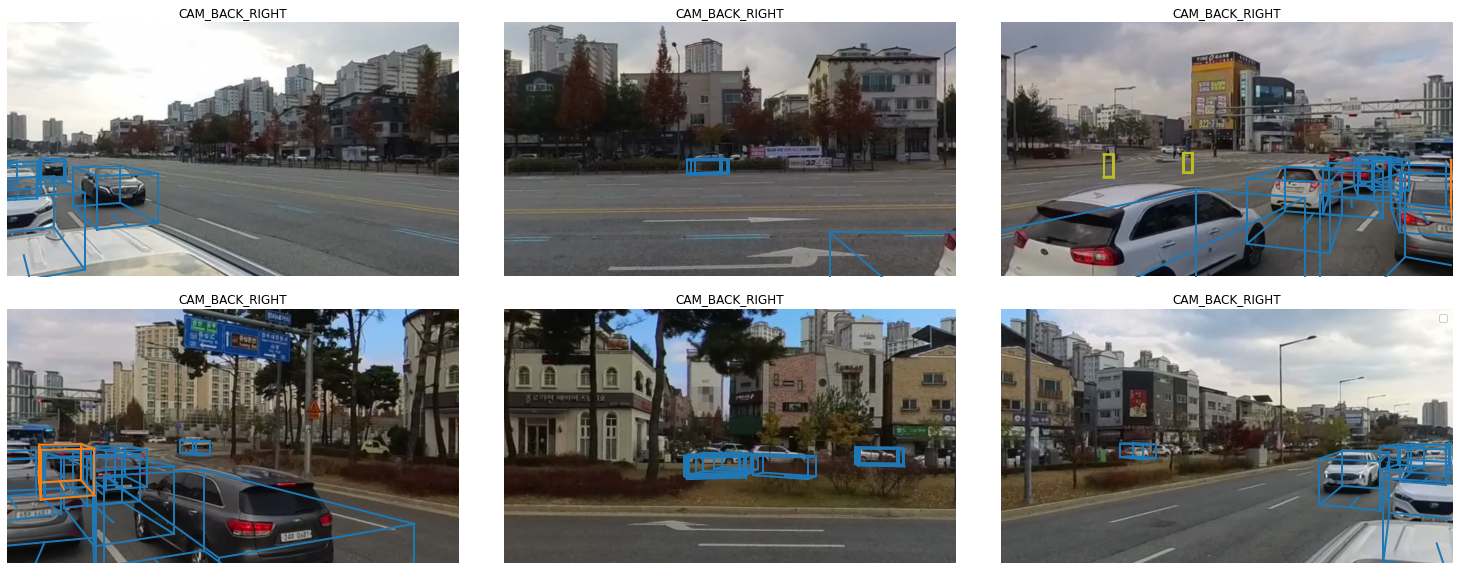

In [235]:
""" BEVDet4D 결과 저장 (bbox in global coord. system) """
dataset.format_single_result_insta360(outputs, cur_data, jsonfile_prefix='./output/')

results_path = './output/pts_bbox/results_nusc.json'
root_path = '../data/nuscenes'

# load predicted results
results = mmcv.load(results_path)['results']

""" Init projection grid and ERP image for VIS """
vis_erp_img = get_erp_img(erp_files[sample_idx]) # current erp image
vis_erp_img = vis_erp_img.to(device)

vis_persp = F.grid_sample(vis_erp_img, vis_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
vis_persp_reshape = F.unfold(vis_persp, kernel_size=(vis_tangent_h, vis_tangent_w), stride=(vis_tangent_h, vis_tangent_w))
vis_persp_reshape = vis_persp_reshape.reshape(1, 3, vis_tangent_h, vis_tangent_w, n_patch).cpu()

# Visualize Tangent patches
# patch_num = 0
# for num_col in num_cols:
#     patch_num = num_col + patch_num

# _, ax = plt.subplots(2, 3, figsize=(24, 10))
# j = 0
# for i in range(patch_num):
#     patch_cnt = i
#     if i == 3:
#         j += 1
#     i = i % 3

#     cur_patch = vis_persp_reshape[0, :, :, :, patch_cnt].permute(1, 2, 0).numpy()
#     cur_patch = cur_patch * 255
#     ax[j, i].imshow(cur_patch[:,:,[2,1,0]].astype(np.uint8), aspect=1)
    
#     # CROP
#     # cur_patch = vis_persp_reshape[0, :, :, :, patch_cnt].permute(1, 2, 0).numpy()
#     # cur_patch = cur_patch * 255
#     # img = cur_patch[:,:,[2,1,0]].astype(np.uint8)
    
#     # vis_crop = (0, 327, 1600, 900)
#     # img = transforms.ToPILImage()(img) # time (ms):  5.7
#     # img = img.crop(vis_crop)
    
#     # ax[j, i].imshow(img, aspect=1)

# plt.show()

""" VIS """
views = [
    'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
    'CAM_BACK', 'CAM_BACK_RIGHT'
]

show_classes=[
    'car',
    'truck',
    'construction_vehicle',
    'bus',
    'trailer',
    'barrier',
    'motorcycle',
    'bicycle',
    'pedestrian',
    'traffic_cone',
]

# Set cameras
threshold = 0.3
show_range = 60

# Set figure size
plt.figure(figsize=(21, 8))

imsize = (1600, 900)
box_vis_level = BoxVisibility.ANY

for i, cam in enumerate(views):
    # Draw camera views
    fig_idx = i + 1 if i < 3 else i + 1
    plt.subplot(2, 3, fig_idx)

    # Set camera attributes
    plt.title(k)
    plt.axis('off')
    plt.xlim(0, 1600)
    plt.ylim(900, 0)

    cur_patch = vis_persp_reshape[0, :, :, :, i].permute(1, 2, 0).numpy()
    cur_patch = cur_patch * 255
    img = cur_patch[:,:,[2,1,0]].astype(np.uint8)

    # Draw images
    plt.imshow(img)

    """ Box coord. transformation: global => ego => sensor => image """
    ego2global_translation = cur_data['ego2global'][:3, -1].cpu().numpy().tolist()
    ego2global_rotation = cur_data['ego2global'][:3, :3].cpu().numpy()
    r = R.from_matrix(ego2global_rotation)
    quat = r.as_quat()
    quat_xyz = quat[:3]
    quat_w = [quat[-1]]
    ego2global_rotation = np.concatenate([quat_w, quat_xyz]).tolist()

    sensor2ego_trans = cur_data['sensor2ego_mats'][i][:3, -1].cpu().numpy().tolist()
    sensor2ego_rot = cur_data['sensor2ego_mats'][i][:3, :3].cpu().numpy().tolist()
    r = R.from_matrix(sensor2ego_rot)
    quat = r.as_quat()
    quat_xyz = quat[:3]
    quat_w = [quat[-1]]
    sensor2ego_rot = np.concatenate([quat_w, quat_xyz]).tolist()

    intrinsic = cur_data['intrinsics'][i].cpu().numpy()
    intrinsic = np.array(intrinsic)
    
    boxes_pred = []
    for box_dict in list(results.values())[0]:
        if box_dict['detection_score'] >= threshold and box_dict['detection_name'] in show_classes:
            box = Box(
                box_dict['translation'],
                box_dict['size'],
                Quaternion(box_dict['rotation']),
                name=box_dict['detection_name']
            )
            
            # box를 global => ego로 이동
            box.translate(-np.array(ego2global_translation))
            box.rotate(Quaternion(ego2global_rotation).inverse)

            # box를 ego => camera로 이동
            box.translate(-np.array(sensor2ego_trans))
            box.rotate(Quaternion(sensor2ego_rot).inverse)
            
            if box_in_image(box, intrinsic, imsize, vis_level=box_vis_level):
                c=cm.get_cmap('tab10')(show_classes.index(box.name))
                
                # box를 camera => image로 이동해서 render
                box.render(plt, view=intrinsic, normalize=True, colors=(c, c, c))

# Set legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(),
           by_label.keys(),
           loc='upper right',
           framealpha=1)

plt.tight_layout(w_pad=0, h_pad=2)
# save_name ='output_%06d.jpg' % idx
# plt.savefig(save_path+save_name)

plt.show()
plt.close()

## Nusc 기반 vis

In [ ]:
# # nuscenes inference
# sum = 0
# cnt = 0
# for j in range(0, 100):
#     cnt += 1
#     data = next(data_iterator)
    
#     sample_token = data['img_metas'][0].data[0][0]['sample_idx']
#     data['img_metas'] = data['img_metas'][0].data

#     with torch.no_grad():

#         data['points'][0].data[0][0] = data['points'][0].data[0][0].to(device)

#         img_inputs = data['img_inputs'][0] # (imgs, rots, trans, intrins, post_rots, post_trans)

#         for i, input_d in enumerate(img_inputs):
#             img_inputs[i] = input_d.to(device)
#         data['img_inputs'][0] = img_inputs
#         # data['img_inputs'][0][0] = data['img_inputs'][0][0].to(device)

#         starter.record()

#         outputs = model(return_loss=False, rescale=True, **data)

#         ender.record()
#         torch.cuda.synchronize()
#         inference_time = starter.elapsed_time(ender)
#         sum += inference_time
#         print("inference time (ms): ", inference_time)
# print(sum / cnt)

In [ ]:
# rank, _ = get_dist_info()
# if rank == 0:
#     dataset.format_single_result(outputs, sample_idx, jsonfile_prefix='./output/')

# results_path = './output/pts_bbox/results_nusc.json'
# root_path = '../data/nuscenes'

# # load predicted results
# results = mmcv.load(results_path)['results']

In [ ]:
# views = [
#     'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
#     'CAM_BACK', 'CAM_BACK_RIGHT'
# ]

# info = infos[vis_idx]

# show_classes=[
#     'car',
#     'truck',
#     'construction_vehicle',
#     'bus',
#     'trailer',
#     'barrier',
#     'motorcycle',
#     'bicycle',
#     'pedestrian',
#     'traffic_cone',
# ]

# # Set cameras
# threshold = 0.3
# show_range = 60

# # Set figure size
# plt.figure(figsize=(21, 8))

# imsize = (1600, 900)
# box_vis_level = BoxVisibility.ANY

# for i, k in enumerate(views):
#     # Draw camera views
#     fig_idx = i + 1 if i < 3 else i + 1
#     plt.subplot(2, 3, fig_idx)

#     # Set camera attributes
#     plt.title(k)
#     plt.axis('off')
#     plt.xlim(0, 1600)
#     plt.ylim(900, 0)

#     img = mmcv.imread(os.path.join(info['cams'][k]['data_path']))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Draw images
#     plt.imshow(img)

#     """
#     Box: global => ego => lidar => sensor => image?
#       or global => ego => sensor => image?
#     """
#     ego2global_translation = info['cams'][k]['ego2global_translation']
#     ego2global_rotation = info['cams'][k]['ego2global_rotation']
    
#     lidar2ego_translation = info['lidar2ego_translation']
#     lidar2ego_rotation =  Quaternion(info['ego2global_rotation'])
    
#     sensor2ego_trans = info['cams'][k]['sensor2ego_translation']
#     sensor2ego_rot = info['cams'][k]['sensor2ego_rotation']
    
#     sensor2lidar_translation = info['cams'][k]['sensor2lidar_translation']
#     sensor2lidar_rotation = info['cams'][k]['sensor2lidar_rotation']
    
#     intrinsic = info['cams'][k]['cam_intrinsic']
#     intrinsic = np.array(intrinsic)
    
#     boxes_pred = []
#     for box_dict in list(results.values())[0]:
#         if box_dict['detection_score'] >= threshold and box_dict['detection_name'] in show_classes:
#             box = Box(
#                 box_dict['translation'],
#                 box_dict['size'],
#                 Quaternion(box_dict['rotation']),
#                 name=box_dict['detection_name']
#             )
            
#             # box를 global => ego로 이동
#             box.translate(-np.array(ego2global_translation))
#             box.rotate(Quaternion(ego2global_rotation).inverse)
            
#             # box를 ego => lidar로 이동
#             # box.translate(np.array(lidar2ego_translation))
#             # box.rotate(Quaternion(lidar2ego_rotation).inverse)
            
#             # box를 lidar => camera로 이동
#             # box.translate(-np.array(sensor2lidar_translation))
#             # box.rotate(Quaternion(matrix=sensor2lidar_rotation).inverse)
            
#             # box를 ego => camera로 이동
#             box.translate(-np.array(sensor2ego_trans))
#             box.rotate(Quaternion(sensor2ego_rot).inverse)
            
#             if box_in_image(box, intrinsic, imsize, vis_level=box_vis_level):
#                 c=cm.get_cmap('tab10')(show_classes.index(box.name))
                
#                 # box를 camera => image로 이동해서 render
#                 box.render(plt, view=intrinsic, normalize=True, colors=(c, c, c))

# # Set legend
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(),
#            by_label.keys(),
#            loc='upper right',
#            framealpha=1)

# plt.tight_layout(w_pad=0, h_pad=2)
# # save_name ='output_%06d.jpg' % idx
# # plt.savefig(save_path+save_name)

# plt.show()
# plt.close()